# MR Perfusion Source Mapping "In Reverse": Maps Venous Territories and Reveals Perfusion Modulation during Neural Activation

This notebook reproduces the figures and processing from the manuscript "MR Perfusion Source Mapping "In Reverse": Maps Venous Territories and Reveals Perfusion Modulation during Neural Activation"

Author of demo: Ekin Karasan, ekin_karasan@berkeley.edu

## Install necessary packages

In [16]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import math
import nibabel as nib
import libs 
import cv2 as cv
from PIL import Image as im
import gdown
import os

%matplotlib notebook

## Download the necessary data

In [26]:
# Download the data
url = 'https://drive.google.com/uc?id=14Agjb-9mleMJMZOa6ScR5aJlJRzVo74o'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14Agjb-9mleMJMZOa6ScR5aJlJRzVo74o
From (redirected): https://drive.google.com/uc?id=14Agjb-9mleMJMZOa6ScR5aJlJRzVo74o&confirm=t&uuid=705c4a70-dccb-4708-8109-5ddfc320f2f4
To: /home/ekin/dataset.zip
100%|██████████| 5.14G/5.14G [00:45<00:00, 112MB/s] 


'dataset.zip'

In [35]:
!unzip dataset.zip 

Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
  inflating: dataset/figure3_dataset.npy  
  inflating: __MACOSX/dataset/._figure3_dataset.npy  
  inflating: dataset/qsm_figure3.nii  
  inflating: __MACOSX/dataset/._qsm_figure3.nii  


In [36]:
!ls dataset

figure3_dataset.npy  qsm_figure3.nii


In [33]:
data = np.load("datasetfigure3_dataset.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'figure3_dataset.npy'

Data dimensions: [# of phase cycles, # of displacement encodings, # of mixing times, # of coils, Nx, Ny]

## Data Processing

In [25]:
# Echo seperation 
kspDconj, kspT1, kspD=libs.DiSpect_SepEcho(data)

# Reshape Displacement Echo
kspD=np.reshape(kspD,(22,14,26,15,40,40))

# Compute Displacement Spectrum (Perfusion Source Maps)
spectrum = sp.rss(np.fft.ifftshift(np.fft.ifft(np.fft.ifft(np.squeeze(kspD),axis=1),axis=0),0),3)

## Load QSM Venogram

In [4]:
qsm = nib.load("qsm_figure3.nii").get_fdata()

## Plot Perfusion Source Maps

Plot Section 1

<IPython.core.display.Javascript object>


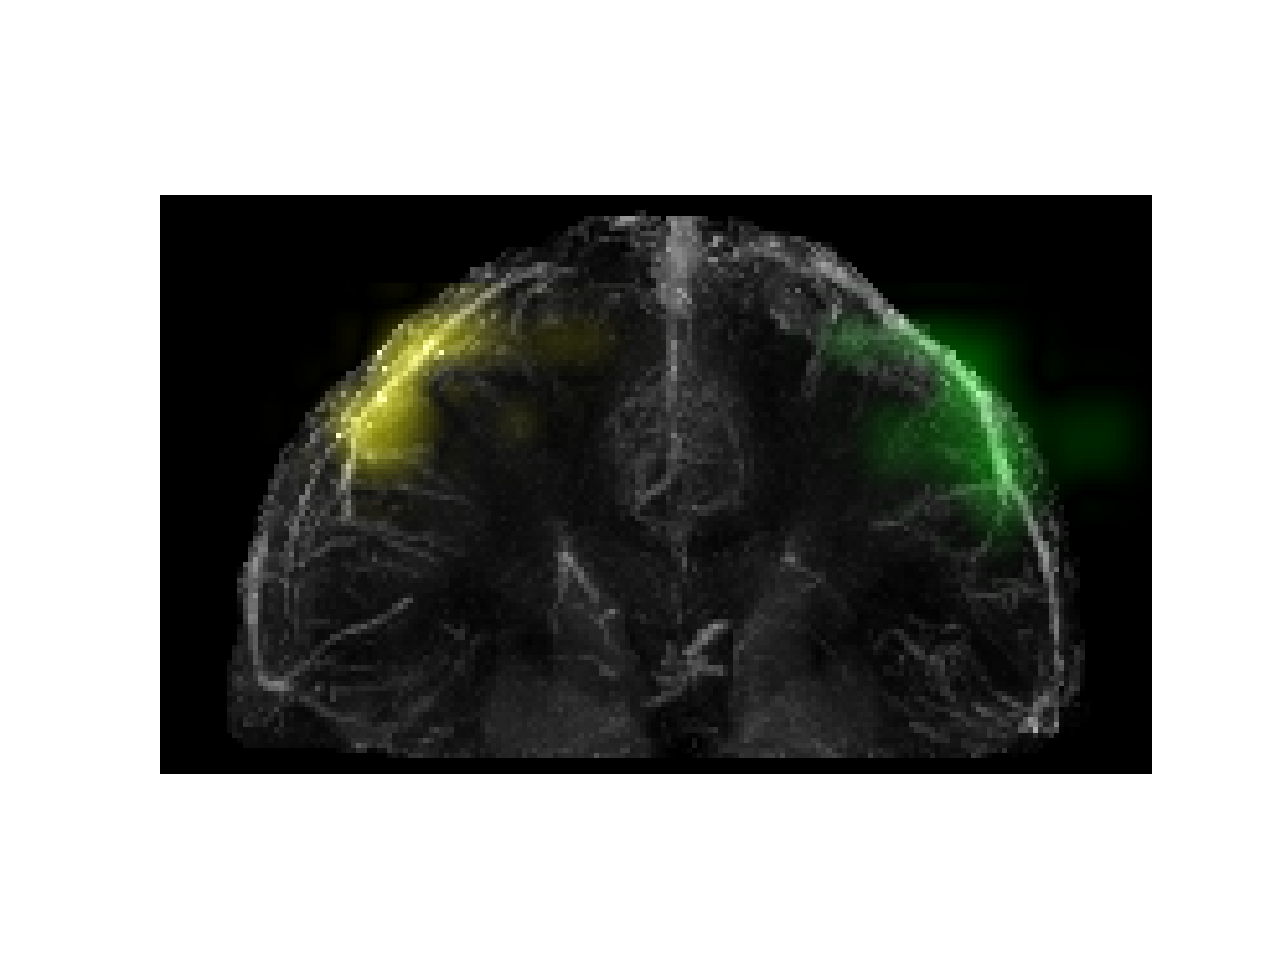

<IPython.core.display.Javascript object>


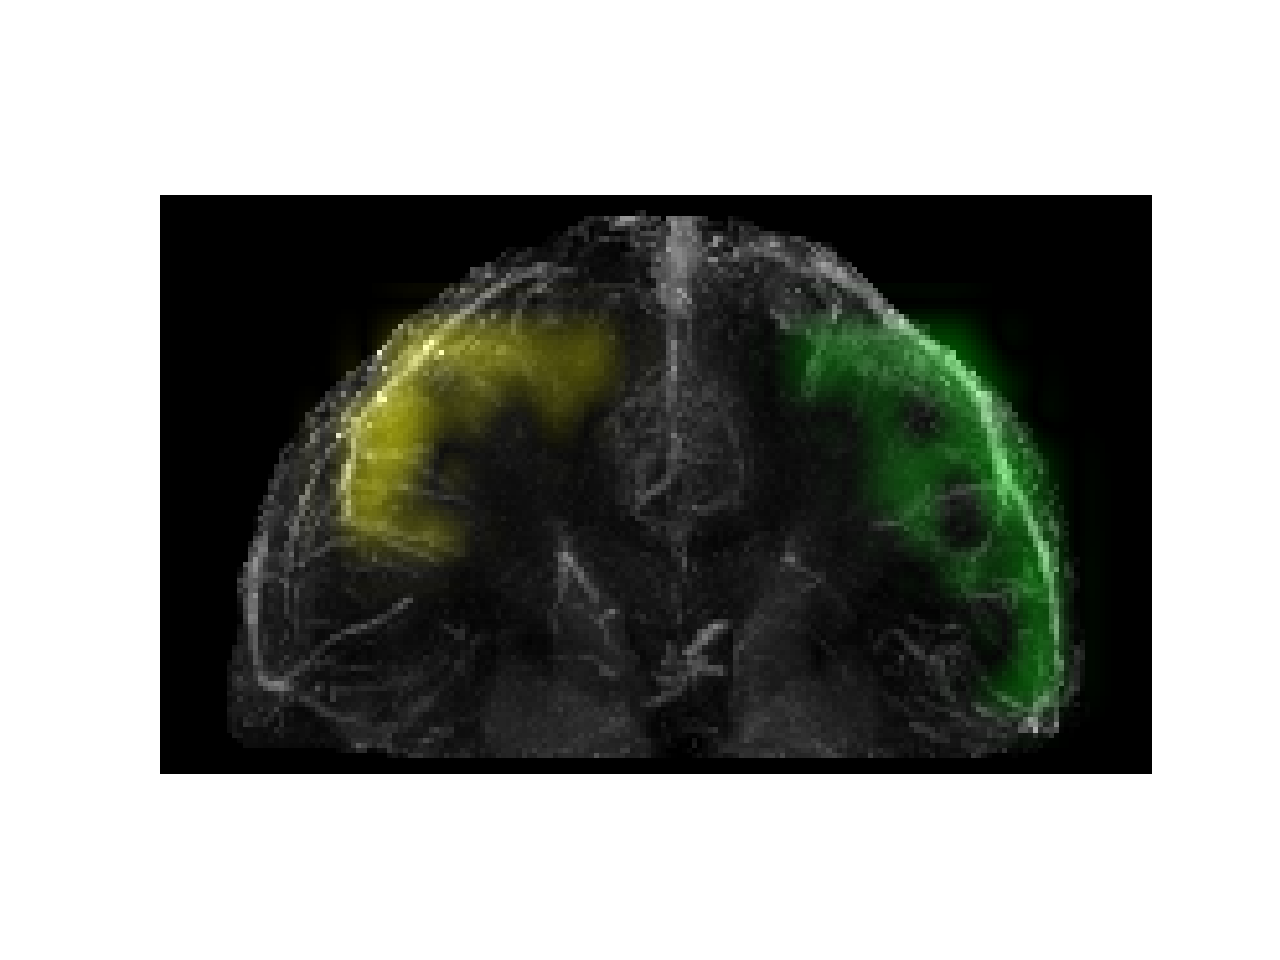

<IPython.core.display.Javascript object>


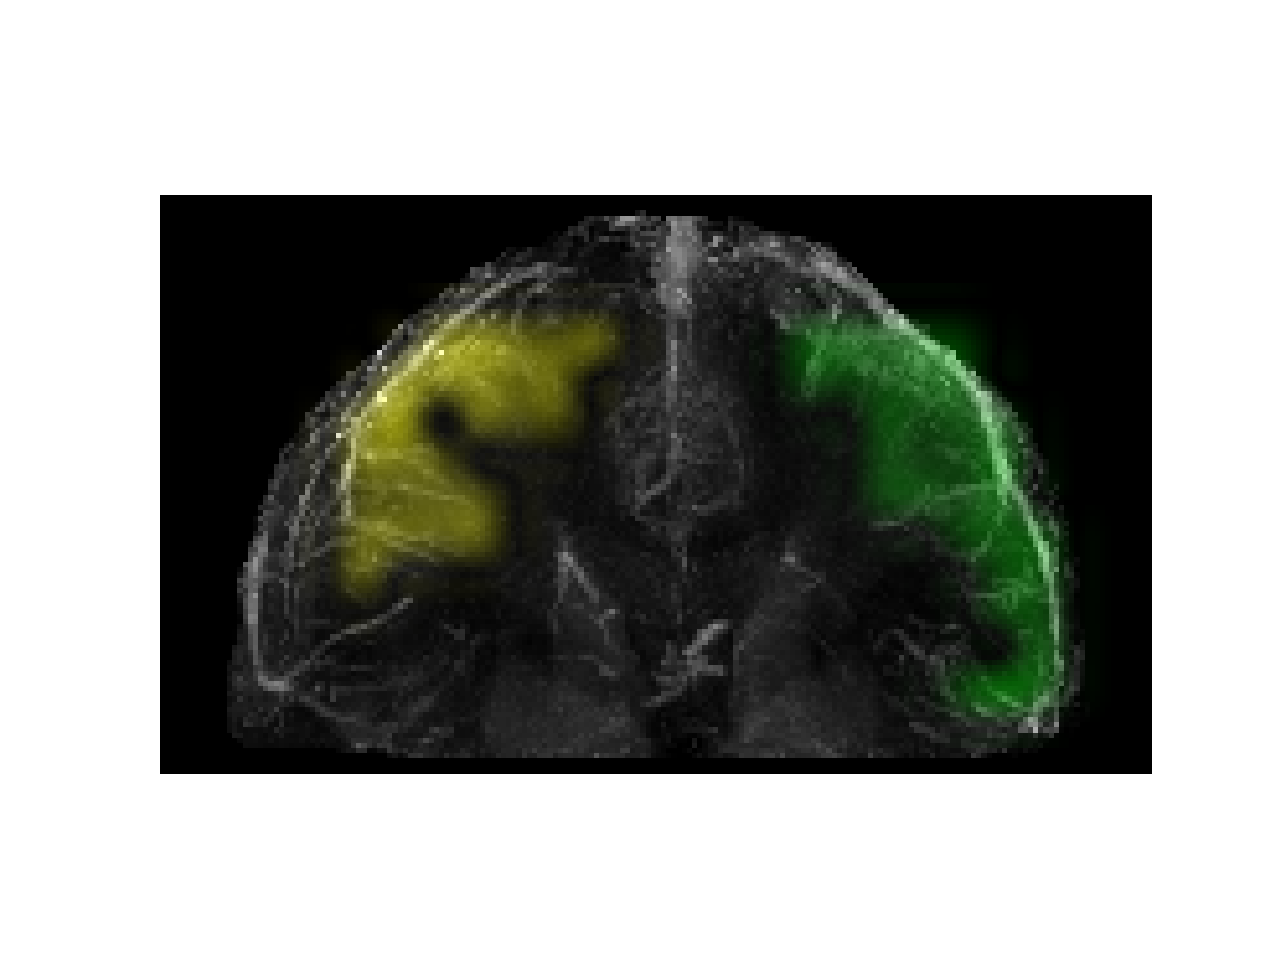

In [7]:
# Source perfusion maps of two selected veins
result_spect2 = spectrum[10:,2:,:,15,27]
result_spect = spectrum[3:15,2:,:,12,15] + spectrum[3:15,2:,:,13,15]

# Coronal projection of qsm venogram
img =np.transpose(np.flip(np.flip(np.max(qsm[:,140:180,:],1),0),1))
imgc = np.zeros((130,224,3))
imgc[:,:,0] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,1] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,2] = 255*np.abs(img)/np.max(np.abs(img))

# Cutoff for plotting
weight_list = [1.25, 1.25,1.25]
weight_list2 = [ 1.18, 1.18,1.18]

# Resize and offsets
gap = -101
resize_factor = (7.5,7.5)
offset = (35,28)

# Plot at three mixing times
for i in range(3):
    plt.figure()
    combined_spectrum2 = np.abs(result_spect[:,:,4*i+4]).copy()
    combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)]=np.zeros(combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)].shape)
    resized = cv.resize(np.roll(np.flip(np.flip(np.transpose(combined_spectrum2)),1),-1,0), dsize=(int(resize_factor[0]*combined_spectrum2.shape[0]), int(resize_factor[1]*combined_spectrum2.shape[1])), interpolation=cv.INTER_CUBIC)
    resized=resized/np.max(resized)

    combined_spectrum3 = np.sqrt(np.abs(result_spect2[:,:,4*i+4]).copy())
    combined_spectrum3[combined_spectrum3<weight_list2[i]*np.mean(combined_spectrum3)]=np.zeros(combined_spectrum3[combined_spectrum3<weight_list2[i]*np.mean(combined_spectrum3)].shape)
    resized2 = cv.resize(np.roll(np.flip(np.flip(np.transpose(combined_spectrum3)),1),-1,0), dsize=(int(resize_factor[0]*combined_spectrum3.shape[0]), int(resize_factor[1]*combined_spectrum3.shape[1])), interpolation=cv.INTER_CUBIC)
    resized2=resized2/np.max(resized2)
    
    overlayed=np.zeros(imgc.shape)
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]:offset[1]+resized.shape[1],0] = resized
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]:offset[1]+resized.shape[1],1] = resized
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]-gap:offset[1]+resized2.shape[1]-gap,1] = overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]-gap:offset[1]+resized2.shape[1]-gap,1] + 0.7*resized2
    overlayed = 255*np.abs(overlayed)/np.max(np.abs(overlayed))

    new_img = cv2.addWeighted(imgc.astype('uint8'), 0.85, overlayed.astype('uint8'), 0.5,0)
    
    plt.imshow(new_img[18:140,15:207,:])
    plt.axis('off')

Plot Section 2

<IPython.core.display.Javascript object>


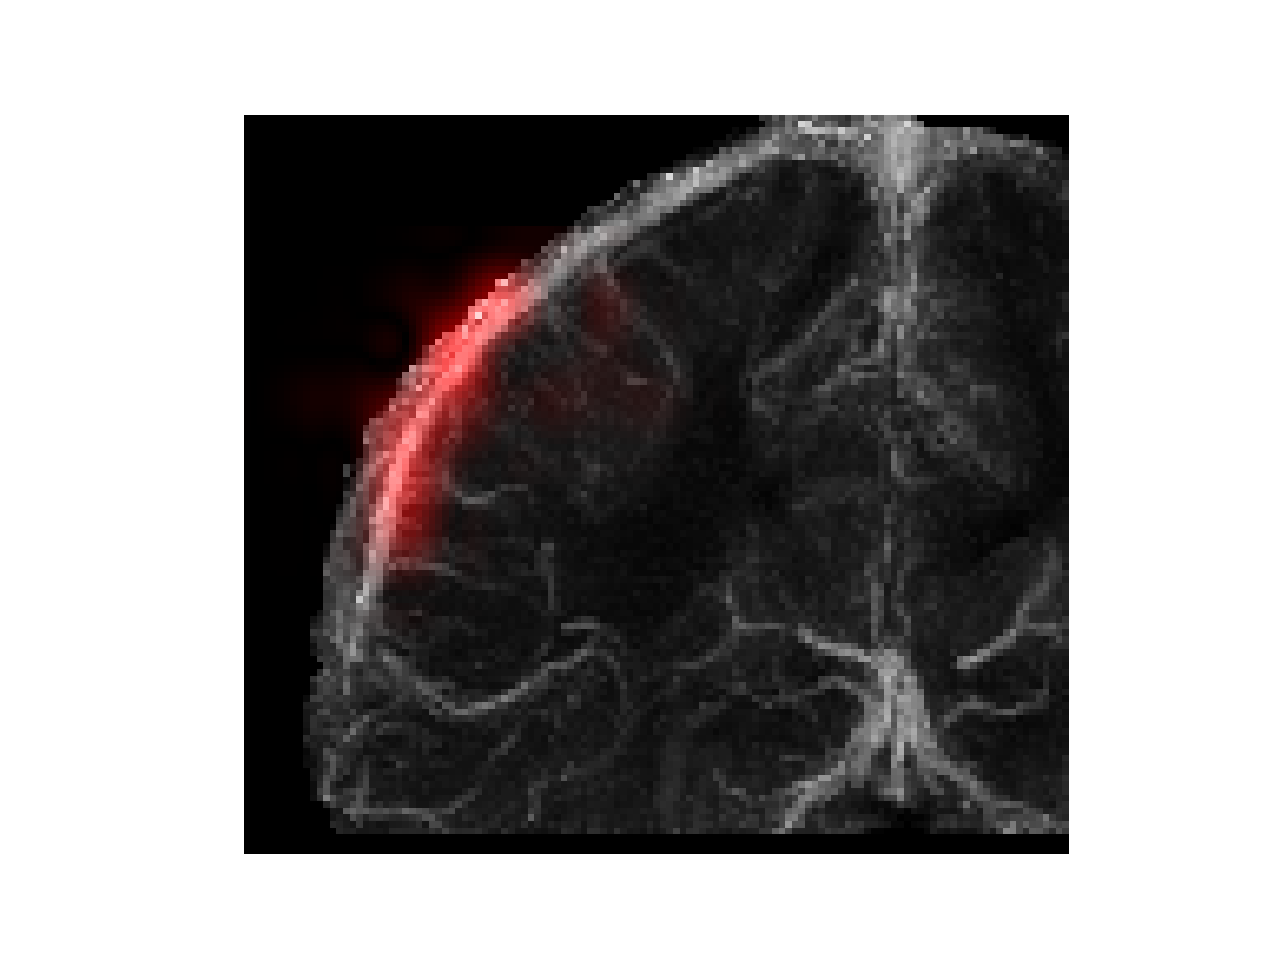

<IPython.core.display.Javascript object>


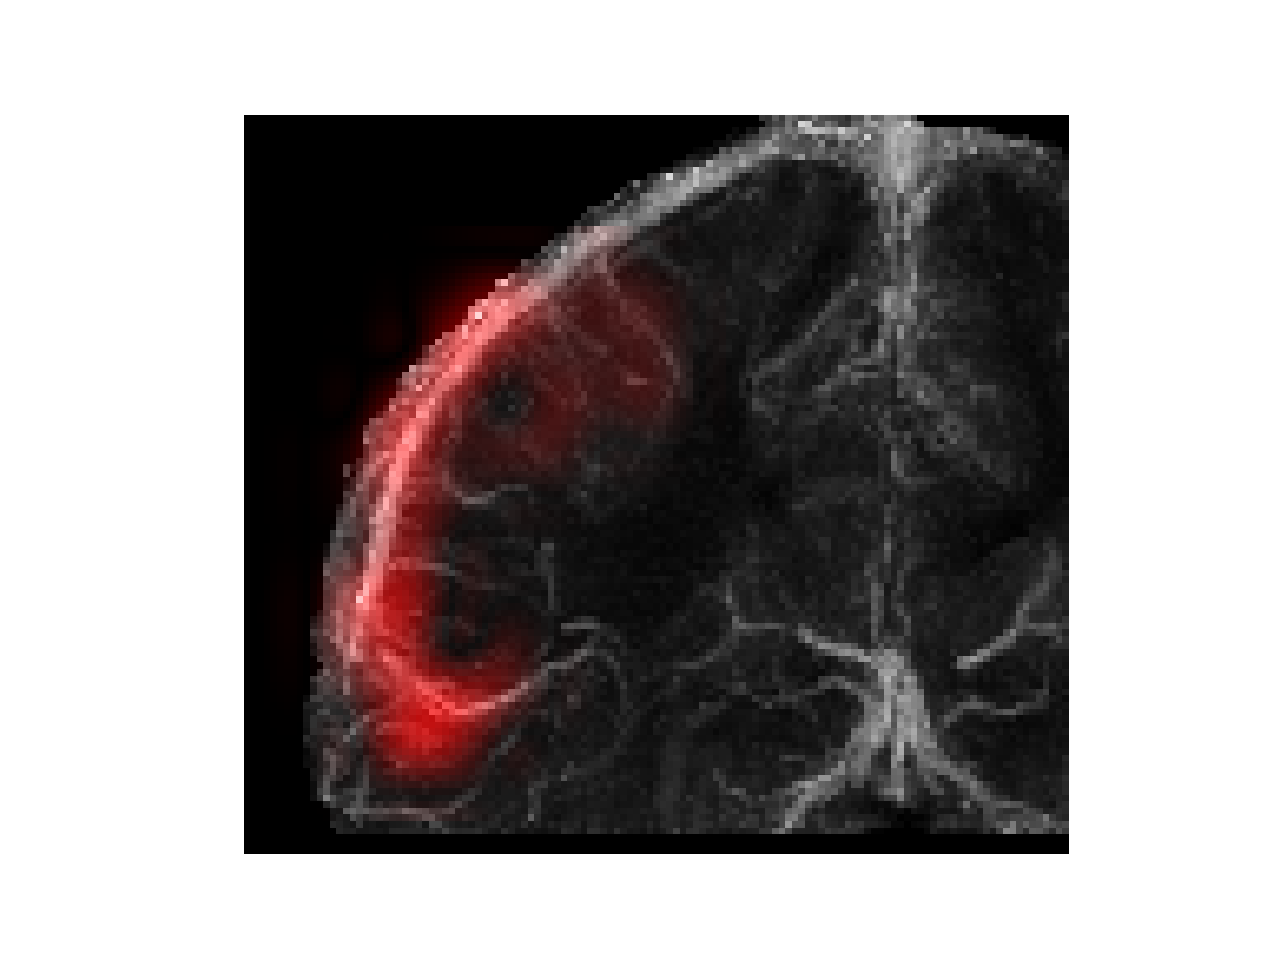

<IPython.core.display.Javascript object>


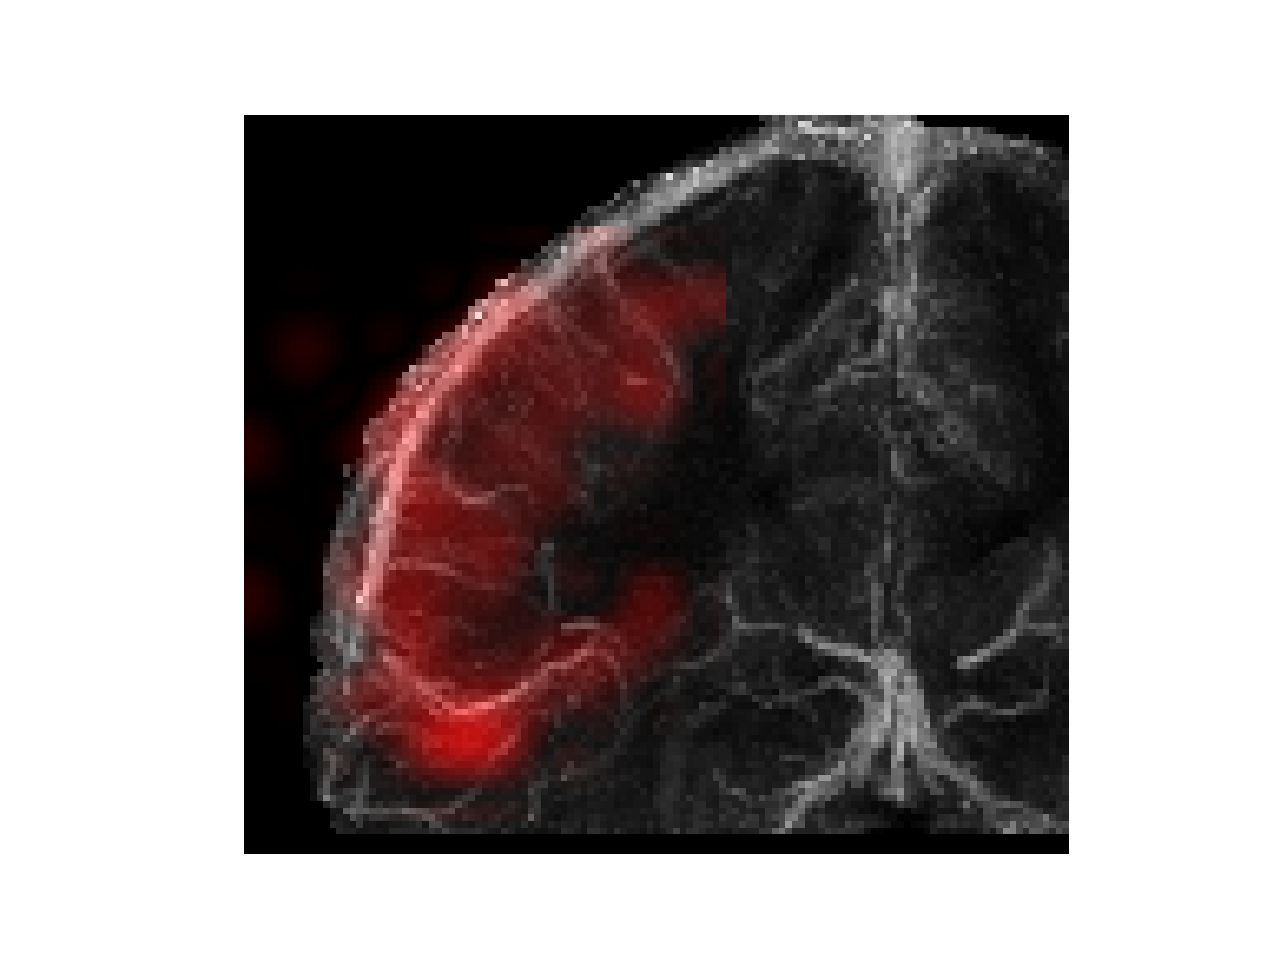

In [8]:
result_spect = spectrum[3:13,2:,:,25,13] + spectrum[3:13,2:,:,26,13]

img =np.transpose(np.flip(np.flip(np.max(qsm[:,90:140,:],1),0),1))
imgc = np.zeros((130,224,3))
imgc[:,:,0] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,1] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,2] = 255*np.abs(img)/np.max(np.abs(img))

weight_list = [ 0.8,  0.8,0.8]
resize_factor = (7.5,7.5)
offset = (35,13)
for i in range(3):
    plt.figure()
    combined_spectrum2 = np.abs(result_spect[:,:,4*i+4]).copy()
    combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)]=np.zeros(combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)].shape)
    resized = cv.resize(np.roll(np.flip(np.flip(np.transpose(combined_spectrum2)),1),-1,0), dsize=(int(resize_factor[0]*combined_spectrum2.shape[0]), int(resize_factor[1]*combined_spectrum2.shape[1])), interpolation=cv.INTER_CUBIC)
    resized=resized/np.max(resized)
    
    overlayed=np.zeros(imgc.shape)
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]:offset[1]+resized.shape[1],0] = resized
    overlayed = 255*np.abs(overlayed)/np.max(np.abs(overlayed))
    new_img = cv2.addWeighted(imgc.astype('uint8'), 0.85, overlayed.astype('uint8'), 0.7,0)
    plt.imshow(new_img[18:140,15:140,:])
    plt.axis('off')

Plot Section 3

<IPython.core.display.Javascript object>


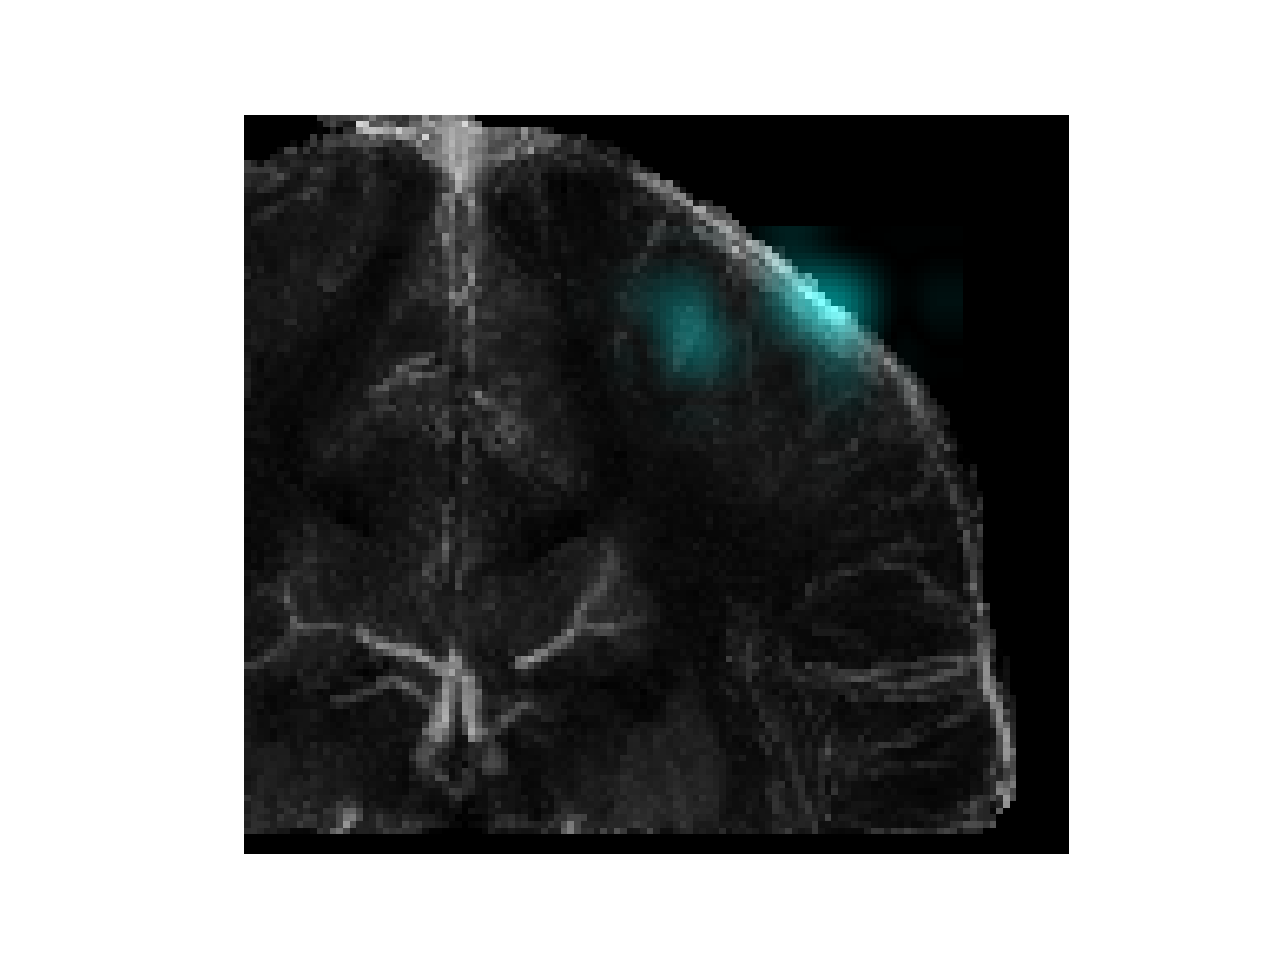

<IPython.core.display.Javascript object>


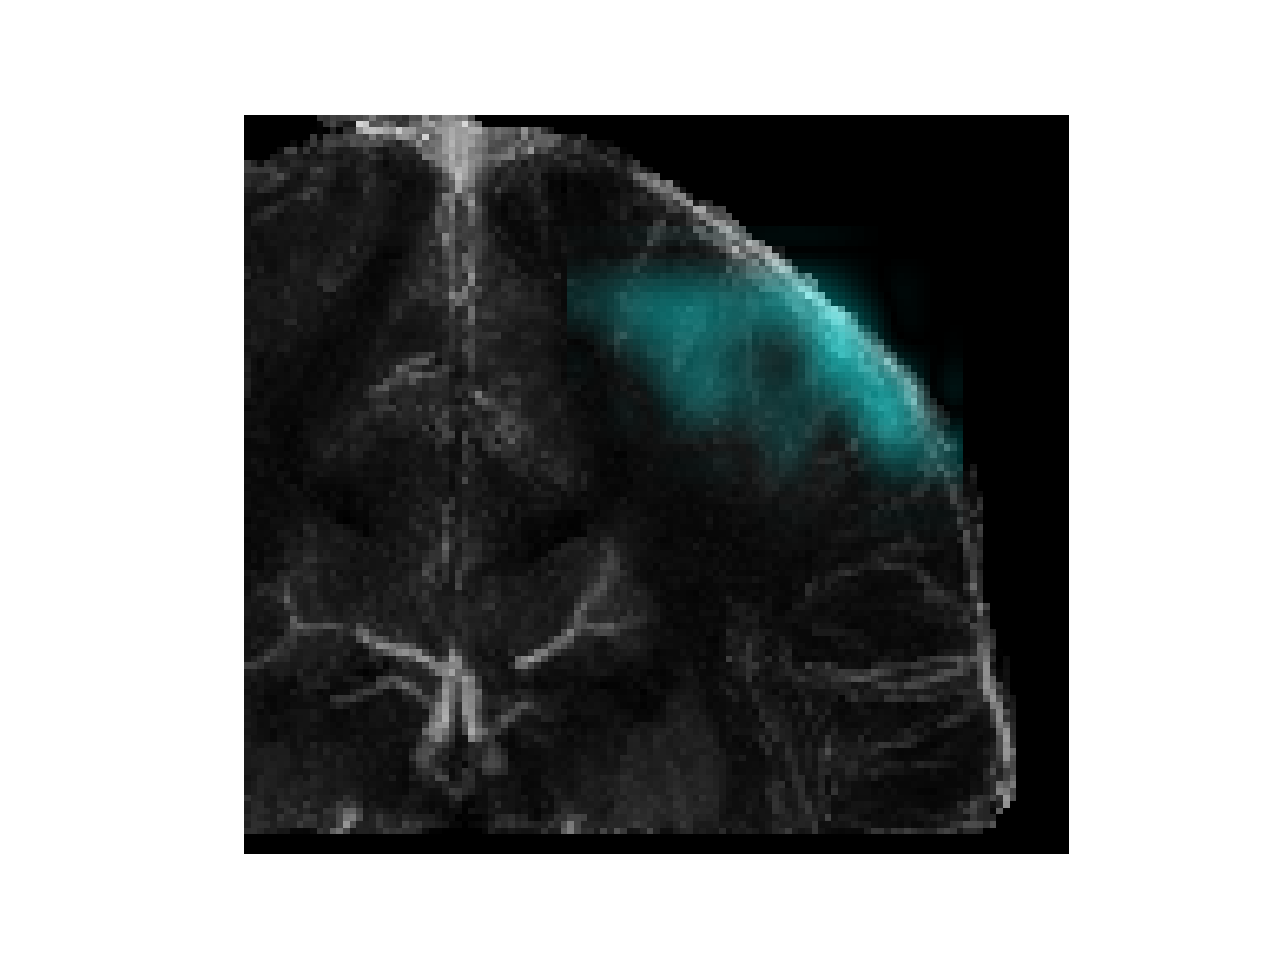

<IPython.core.display.Javascript object>


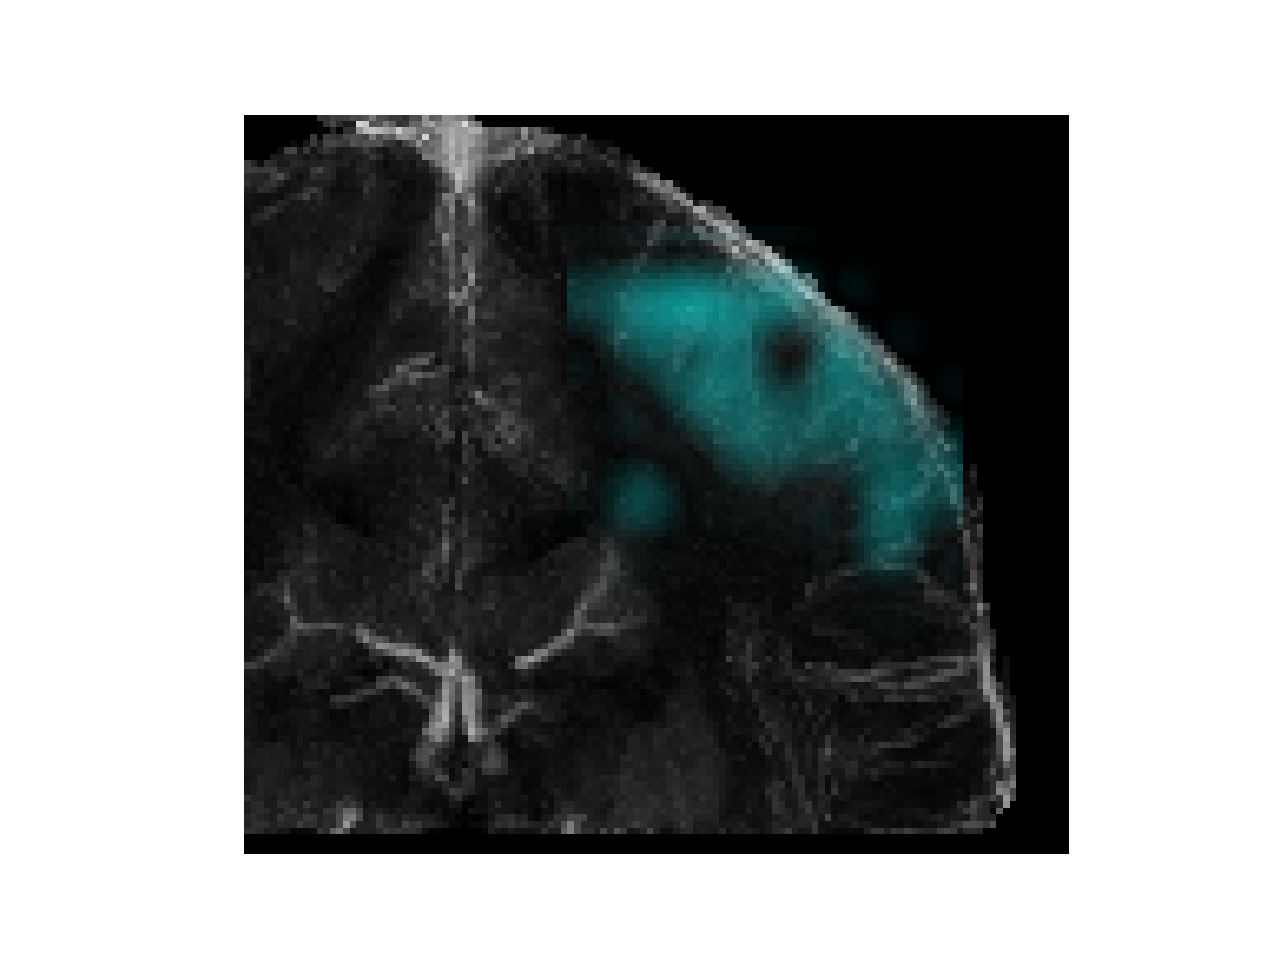

In [9]:
result_spect = spectrum[10:18,2:,:,19,28]+spectrum[10:18,2:,:,20,28] 
img =np.transpose(np.flip(np.flip(np.max(qsm[:,110:140,:],1),0),1))
imgc = np.zeros((130,224,3))
imgc[:,:,0] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,1] = 255*np.abs(img)/np.max(np.abs(img))
imgc[:,:,2] = 255*np.abs(img)/np.max(np.abs(img))

weight_list = [ 1.2, 1.2,1.2]
resize_factor = (7.5,7.5)
offset = (35,131)
for i in range(3):
    plt.figure()
    combined_spectrum2 = np.abs(result_spect[:,:,4*i+4]).copy()
    combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)]=np.zeros(combined_spectrum2[combined_spectrum2<weight_list[i]*np.mean(combined_spectrum2)].shape)
    resized = cv.resize(np.roll(np.flip(np.flip(np.transpose(combined_spectrum2)),1),-1,0), dsize=(int(resize_factor[0]*combined_spectrum2.shape[0]), int(resize_factor[1]*combined_spectrum2.shape[1])), interpolation=cv.INTER_CUBIC)
    resized=resized/np.max(resized)
    
    overlayed=np.zeros(imgc.shape)
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]:offset[1]+resized.shape[1],1] = resized
    overlayed[offset[0]:offset[0]+resized.shape[0],offset[1]:offset[1]+resized.shape[1],2] = resized
    overlayed = 255*np.abs(overlayed)/np.max(np.abs(overlayed))
    new_img = cv2.addWeighted(imgc.astype('uint8'), 0.85, overlayed.astype('uint8'), 0.5,0)
    plt.imshow(new_img[18:140,82:207,:])
    plt.axis('off')
